In [4]:
# Загрузка биьлиотек
import pandas as pd
import sqlite3 as db

import datetime as dt
import multiprocessing
from multiprocessing import Pool, Manager

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import pprint
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from package.select_run_test import SampleComparisonTest

# 2. Оценка эффективности первой рекламной компании

## 2.1. Формирование данных AB-тестирования из предложенных заказчиком источников

In [6]:
# Загрузим итоговый датаcет из хранилища
connection = db.connect('data/purchases.db')
print("База данных создана и подключена")
query = 'SELECT * FROM full_table'
df_all = pd.read_sql_query(query, connection)
print("Таблица заполнена")
connection.close()
print("Соединение с базой данных закрыто")
df_all.head(3)

База данных создана и подключена
Таблица заполнена
Соединение с базой данных закрыто


,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,Стол Outventure,зеленый,1499,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072


In [7]:
# Прочитаем признаки проведения AB-тестов
# Загрузим признаки тестовой и контрольной выборок
def f_indexes(df, col, file_name, value):
    def f(x, y, value, indexes):
        if x in indexes:
            return value
        else:
            return y
    
    indexes = list()
    with open(file_name) as file:
        while True:
            line = file.readline()
            if not line:
                break
            row = line[:-1].replace(' ', ',').replace(';', ',').split(',')
            for elem in row:
                if elem.isdigit():
                    indexes.append(int(elem))
    
    # Оставим только уникальные значения индексов
    indexes = list(set(indexes))
    print(f'Количество записей {file_name[-12:-4]}: {len(indexes)}')

    df[col] = df.apply(lambda x: f(x.id, x[col], value, indexes), axis=1)

    return df

In [8]:
# Добавим в датасет признак тестовой группы
col = 'test'
df_all[col] = None

# Заполним признак данными о тестовой группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_positive.txt', 1)

# Заполним признак данными о контрольной группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_negative.txt', 0)

Количество записей positive: 5016
Количество записей negative: 5009


In [41]:
# Получим датасет выбранный для AB тестирования первой маркетенговой компании, в котором
# с целью исключения влтяния на расчёт AB теста второй рекламной кампании
# уберём записи за 15-й день в городе 1134
df_AB = df_all[~df_all.test.isna() & ~((df_all.dt == 14) & (df_all.city == 1134))]
print(f'Количесвто записей для расчёта AB теста: {df_AB.shape[0]}')
print(f'Количество записей positive: {len(df_AB[df_AB.test == 1])}')
print(f'Количество записей negative: {len(df_AB[df_AB.test == 0])}')

Количесвто записей для расчёта AB теста: 119214
Количество записей positive: 63696
Количество записей negative: 55518


In [42]:
# Проверим сохранилась ли сбалансированность датастеа
df_AB_positive = df_AB[df_AB.test == 1].groupby('id').agg({'product': 'count'})
df_AB_negative = df_AB[df_AB.test == 0].groupby('id').agg({'product': 'count'})
print(f'Количество записей positive:: {len(df_AB_positive)}')
print(f'Количество записей negative:: {len(df_AB_negative)}')

Количество записей positive:: 4997
Количество записей negative:: 4995


**Вывод:** количество покупателей, совершивших покупки в тестовой и контрольной группах сбалансировано, соответсвенно условий релевантности групп при тестировании - считаtv выполненным.

## 2.2. Формирование выборок метрик эффективности проведённой рекламной кампании

Эффективность проведённой рекламной кампании целесообразно проверить по увеличению стоимости покупок покупателями

In [43]:
# Датасеты тестовой и контрольной групп
df_test = df_AB[df_AB.test == 1]
df_control = df_AB[df_AB.test == 0]

In [44]:
# Сформируем выборки по стоимости покупок покупателей
df_test_cost = df_test.groupby('dt').agg({'cost': 'sum'})
df_control_cost = df_control.groupby('dt').agg({'cost': 'sum'})

In [45]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_cost['cost'], df_control_cost['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 0.000092%
  - вторая выборка: 0.000000%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 18.728445%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 9.208505957758462e-07,
  'p-value df2': 5.721716029032271e-15},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 0.18728444770281727}}

**Вывод:** проведение маркетинговой компании совокупно по всей тестируемой группе покупателей не привело к статистически значимым изменениям. Возможно изменения произошли по отдельным группам (кластерам).

## 2.3. Кластаризация покупателей

### 2.3.1. Формирование двумерного пространства признаков

In [137]:
df_AB.head(3)

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,test,X,Y
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,-17.219559,-33.895054
1,0,Стол Outventure,зеленый,1499,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,8.005724,17.396294
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,5.835960,19.730255


In [140]:
# Получим датасет покупателей, участвовавшихх в AB тесте
df_buyer = df_AB.groupby(['id']).\
        agg({'product': 'count', 'cost': 'sum', 'product_sex': 'max',
             'dt': 'nunique', 'gender': 'max', 'age': 'max',
            'education': 'max', 'city': 'max', 'country': 'max', 'personal_coef': 'max',
             'test': 'max'})
df_buyer

,product,cost,product_sex,dt,gender,age,education,city,country,personal_coef,test
id,,,,,,,,,,,
0,3,19897,2.0,2,0.0,36,среднее,1201,32,0.5072,1.0
3,4,14596,2.0,3,1.0,31,среднее,1134,32,0.4304,0.0
4,7,31093,2.0,4,0.0,35,среднее,1134,32,0.5072,1.0
6,15,84085,2.0,9,1.0,52,среднее,1188,32,0.4304,1.0
9,10,63290,2.0,5,0.0,48,среднее,1134,32,0.5072,0.0
...,...,...,...,...,...,...,...,...,...,...,...
177946,10,68800,2.0,7,1.0,35,среднее,1134,32,0.4304,1.0
177963,5,21685,2.0,5,0.0,33,среднее,250,32,0.5072,0.0
177965,17,61183,2.0,12,0.0,62,среднее,1192,32,0.5072,1.0


In [143]:
from sklearn.preprocessing import StandardScaler
# Выделим числовые признаки
df_num = df_buyer[df_buyer.columns[(df_buyer.dtypes == 'int64') | (df_buyer.dtypes == 'float64')]].\
                drop(columns=['test'], axis=1)
# Масштабируем числовые признаки
features = [col for col in df_num.columns]
scaler = StandardScaler()
df_num_sc = pd.DataFrame(data=scaler.fit_transform(df_num[features]), columns=df_num[features].columns)

In [144]:
# Выделим категориальные признаки
df_cat = df_buyer[df_buyer.columns[df_buyer.dtypes == 'object']]
# Закадируем категориальные признаки
oe = OrdinalEncoder()
df_cat_le = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
# Масштабируем числовые признаки
scaler = StandardScaler()
df_cat_sc = pd.DataFrame(data=scaler.fit_transform(df_cat_le), columns=df_cat.columns)

In [145]:
# Объединим числовые и категориальные признаки
df_num_cat_sc = df_num_sc.join(df_cat_sc)
df_num_cat_sc.head(5)

,product,cost,product_sex,dt,gender,age,city,country,personal_coef,education
0,-0.526111,-0.370964,0.420913,-0.851654,-1.155712,-0.197073,0.372752,0.010167,0.796827,0.506497
1,-0.467202,-0.416314,0.420913,-0.664405,0.865267,-0.608118,0.021953,0.010167,-0.453659,0.506497
2,-0.290476,-0.275182,0.420913,-0.477156,-1.155712,-0.279282,0.021953,0.010167,0.796827,0.506497
3,0.180794,0.178164,0.420913,0.459090,0.865267,1.118272,0.304687,0.010167,-0.453659,0.506497
4,-0.113750,0.000263,0.420913,-0.289906,-1.155712,0.789436,0.021953,0.010167,0.796827,0.506497


In [146]:
from sklearn.manifold import TSNE

In [147]:
# Преобразуем пространство признаков в двухмерное
tsne = TSNE(n_components=2)
df_num_cat_sc_tsne = tsne.fit_transform(df_num_cat_sc)
df_num_cat_sc_tsne

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[-27.42965  , -79.96617  ],
       [ 50.58157  ,  17.917238 ],
       [ -8.465991 , -63.828197 ],
       ...,
       [ 21.5428   , -16.939325 ],
       [-63.27647  , -15.002881 ],
       [ -1.5540584,  18.75787  ]], dtype=float32)

In [148]:
# Добавим координаты двумерного пространства в датасет
df_buyer[['X', 'Y']] = df_num_cat_sc_tsne
df_buyer.head(3)

,product,cost,product_sex,dt,gender,age,education,city,country,personal_coef,test,X,Y
id,,,,,,,,,,,,,
0,3,19897,2.0,2,0.0,36,среднее,1201,32,0.5072,1.0,-27.429649,-79.966171
3,4,14596,2.0,3,1.0,31,среднее,1134,32,0.4304,0.0,50.581570,17.917238
4,7,31093,2.0,4,0.0,35,среднее,1134,32,0.5072,1.0,-8.465991,-63.828197


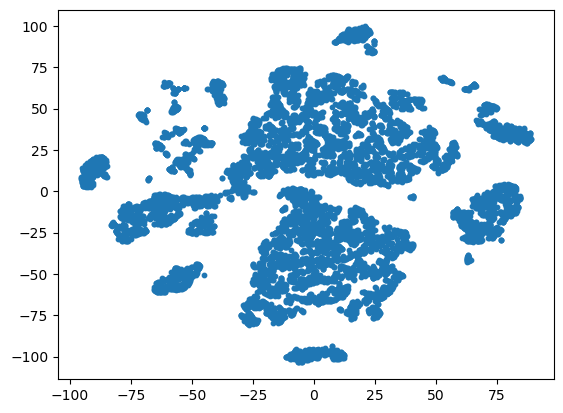

In [149]:
import matplotlib.pyplot as plt
# Визуализируем полученные координаты точек двухмерного пространства
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10);

### 2.3.2. Кластаризация методом К-средних

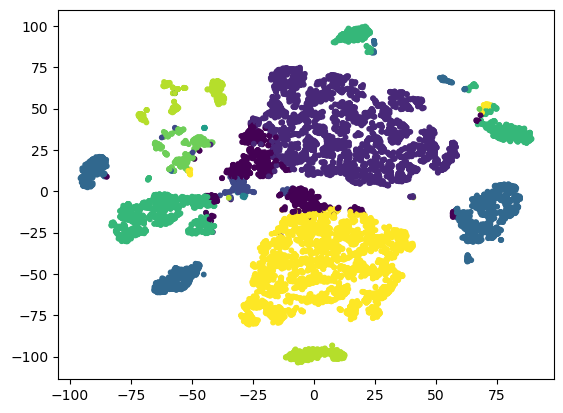

In [150]:
from sklearn.cluster import AgglomerativeClustering, KMeans
# Предварительное разбиение на 10 кластеров
kmeans = KMeans(n_clusters=10, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans.labels_);

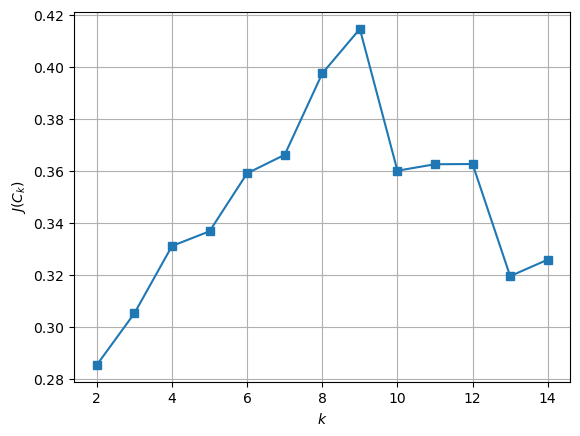

In [151]:
from sklearn.metrics import silhouette_score
# Определение оптимального количества кластеров
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(df_num_sc)
    preds = kmeans.predict(df_num_sc)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_num_sc, preds))

# графическое отображение "колена", характеризующего оптимальное количесвто кластеров
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

Проверим визуально наиболее ярко выраженные участки графика (колени)

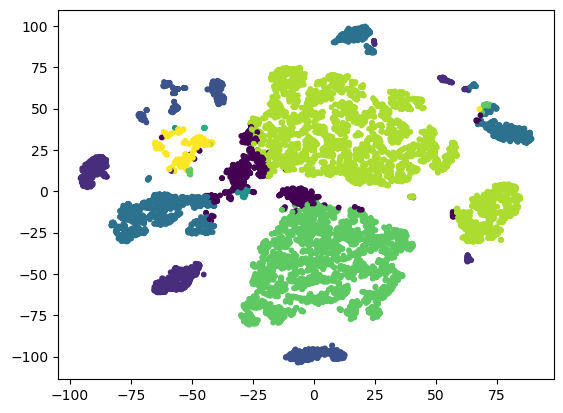

In [153]:
# Разбиение на 9 кластера
kmeans_9 = KMeans(n_clusters=9, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_9.labels_);

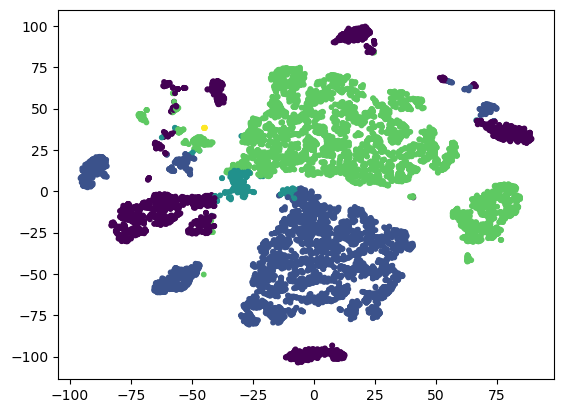

In [154]:
# Разбиение на 10 кластера
kmeans_10 = KMeans(n_clusters=5, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_10.labels_);

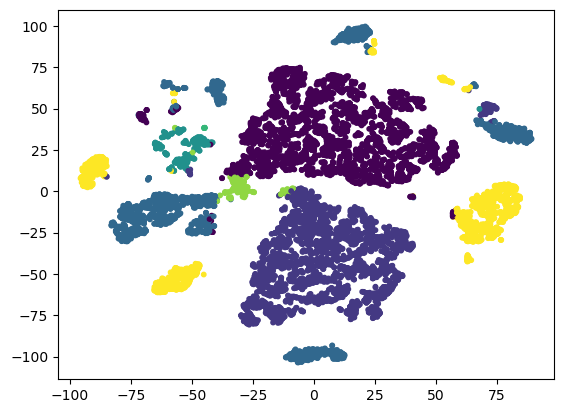

In [155]:
# Разбиение на 12 кластера
kmeans_12 = KMeans(n_clusters=7, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_12.labels_);

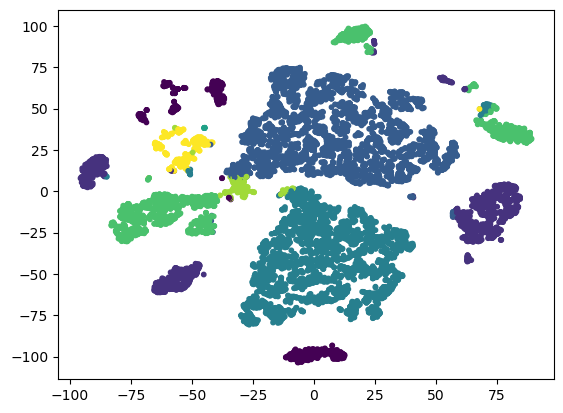

In [156]:
# Разбиение на 13 кластера
kmeans_13 = KMeans(n_clusters=8, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_buyer['X'], df_buyer['Y'], s=10, c=kmeans_13.labels_);

**Выводы:** Визуально видно что при увеличении количества кластеров разделение покупателей на явные группы не улучшается. Кроме того при увеличении числа кластеров рвозрастает вероятность ошибочного отнесения точек пространства к кластерам. Таким образом целесооьразно выбрать минималное количество кластеров представленной в оптимально выбранном списке "количества кластеров", то есть 9 кластеров.

### 2.3.3. Определим по каким основным признакам сгруппировались кластеры

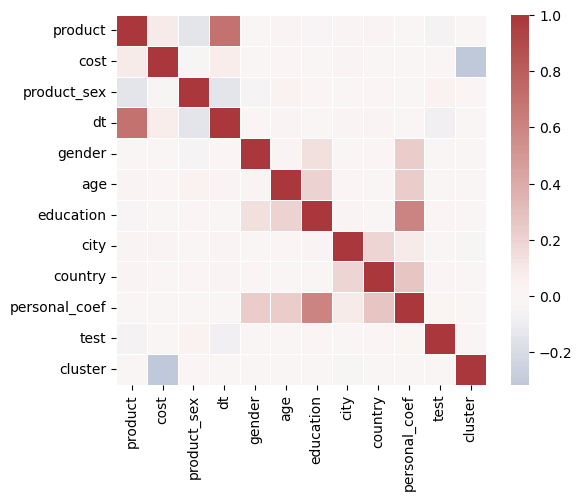

In [157]:
import seaborn as sns
# Сформируем признаки кластеров для датасета
df_cluster = pd.DataFrame(data=kmeans_9.labels_, columns=['cluster'])
# Добавим признаки кластеров в датасет клииентов
df_cluster =df_buyer.join(df_cluster).drop(['X', 'Y'], axis=1)
# Выделим корреляцуии кластеров и иных признаков у покупок
corr_mat = df_cluster.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_mat, cmap='vlag', center=0, square=True, linewidths=.5)
plt.show()

In [159]:
# Выведем коэффициент влияния отдельных поведенческих патернов на отнесение покупок к кластерам 
corr_mat.cluster.sort_values(ascending=False)[1:]

product_sex      0.011660
education        0.002680
test            -0.000099
age             -0.004817
country         -0.005919
personal_coef   -0.006523
dt              -0.019702
product         -0.021287
gender          -0.023330
city            -0.037559
cost            -0.314805
Name: cluster, dtype: float64

**Вывод**: Разбиение на кластеры не выявило признаки, по группе которых можно распределить клиентов таким образом что бы они проявляли одинаковые поведенческие патерны. Наблюдается слабая корреляция кластеров по сумме покупки.

### 2.3.4. Проведём анализ изменения стоимости покупок в выделенных кластерах

In [164]:
df_cluster

,product,cost,product_sex,dt,gender,age,education,city,country,personal_coef,test,cluster
id,,,,,,,,,,,,
0,3,19897,2.0,2,0.0,36,среднее,1201,32,0.5072,1.0,6.0
3,4,14596,2.0,3,1.0,31,среднее,1134,32,0.4304,0.0,7.0
4,7,31093,2.0,4,0.0,35,среднее,1134,32,0.5072,1.0,6.0
6,15,84085,2.0,9,1.0,52,среднее,1188,32,0.4304,1.0,7.0
9,10,63290,2.0,5,0.0,48,среднее,1134,32,0.5072,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
177946,10,68800,2.0,7,1.0,35,среднее,1134,32,0.4304,1.0,NaN
177963,5,21685,2.0,5,0.0,33,среднее,250,32,0.5072,0.0,NaN
177965,17,61183,2.0,12,0.0,62,среднее,1192,32,0.5072,1.0,NaN


In [166]:
df_test = df_cluster[df_cluster.test == 1].groupby('cluster').agg({'cost': 'sum'})
df_control = df_cluster[df_cluster.test == 0].groupby('cluster').agg({'cost': 'sum'})

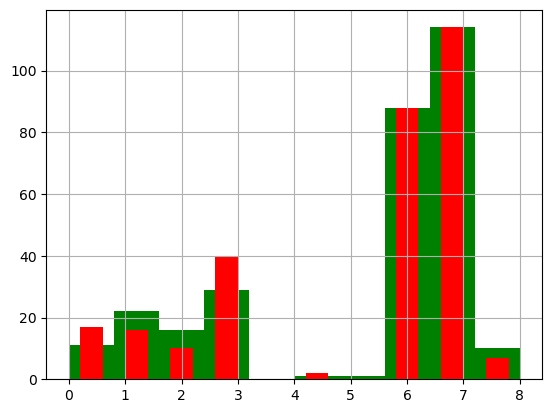

In [168]:
# Построим распределение
df_cluster[df_cluster.test == 1]['cluster'].hist(color='green');
df_cluster[df_cluster.test == 0]['cluster'].hist(color='red', rwidth = 0.5);

**Вывод:** По кластерам покупателей можно увидеть изменения стоимостей продаж, однако рекомендации о воздействии на покупателей в отдельной категории признаков сформировать нельзя, так как кластеры не имеют явной корреляции с отдельными признаками. Таким образом можно порекомендовать проводить рекламные компании среди клиентов, которые предварительно распределены по кластерам и попавшим в 1,2,8 кластеры, так как клиенты попавшие в данные кластеры увеличивают суммы покупок. 